Loaded 3650 days of temperature data.
Epoch [50/200], Loss: 0.3966
Epoch [100/200], Loss: 0.3544
Epoch [150/200], Loss: 0.3426
Epoch [200/200], Loss: 0.3323


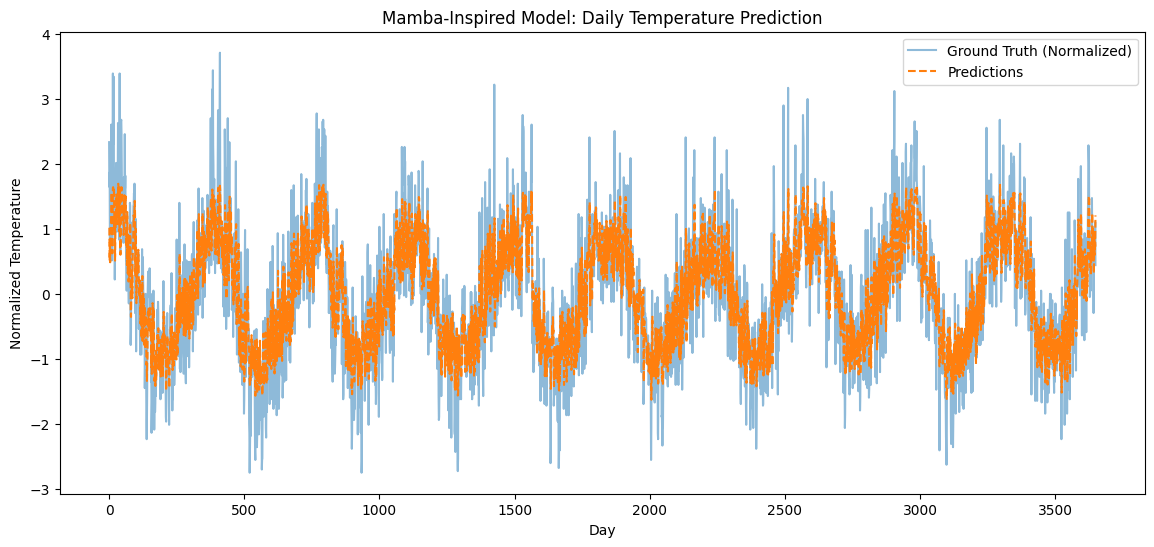

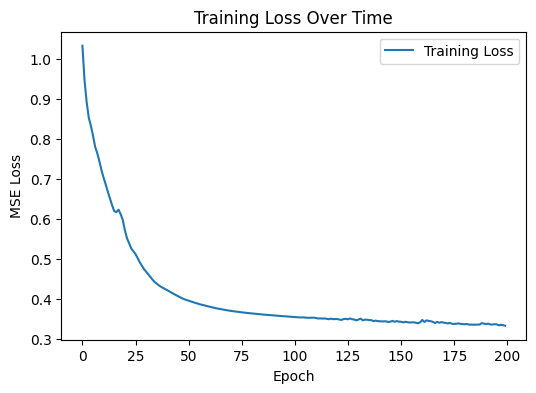

In [8]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlopen


torch.manual_seed(42)
np.random.seed(42)

def load_temperature_data():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
    df = pd.read_csv(url)
    temps = df['Temp'].values
    temps = (temps - np.mean(temps)) / np.std(temps)
    return torch.FloatTensor(temps).unsqueeze(-1)


class SimpleMamba(nn.Module):
    def __init__(self, input_dim=1, state_dim=32, output_dim=1):
        super(SimpleMamba, self).__init__()
        self.state_dim = state_dim


        self.A = nn.Parameter(torch.zeros(state_dim, state_dim))
        nn.init.xavier_normal_(self.A, gain=0.1)
        self.B = nn.Parameter(torch.zeros(input_dim, state_dim))
        nn.init.xavier_normal_(self.B, gain=0.1)
        self.C = nn.Parameter(torch.zeros(output_dim, state_dim))
        nn.init.xavier_normal_(self.C, gain=0.1)


        self.select_gate = nn.Linear(input_dim + state_dim, state_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_length, input_dim = x.size()
        h = torch.zeros(batch_size, self.state_dim)
        outputs = []

        for t in range(seq_length):
            x_t = x[:, t, :]
            gate_input = torch.cat([x_t, h], dim=-1)
            gate = self.sigmoid(self.select_gate(gate_input))


            h_next = h @ self.A + x_t @ self.B
            h = gate * h_next
            h = h / (torch.norm(h, dim=-1, keepdim=True) + 1e-6)
            y_t = h @ self.C.T
            outputs.append(y_t)

        return torch.stack(outputs, dim=1)


def train_model(model, data, epochs=200, lr=0.005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    inputs = data[:-1].unsqueeze(0)  # [1, seq_length-1, 1]
    targets = data[1:].unsqueeze(0)  # [1, seq_length-1, 1]

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Stopping training.")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return losses


def main():
    # Load data
    data = load_temperature_data()
    seq_length = len(data)
    print(f"Loaded {seq_length} days of temperature data.")


    model = SimpleMamba(input_dim=1, state_dim=32, output_dim=1)

    # Train
    losses = train_model(model, data, epochs=200)

    # Predict
    model.eval()
    with torch.no_grad():
        inputs = data[:-1].unsqueeze(0)
        predictions = model(inputs).squeeze(0).numpy()

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.plot(data.numpy(), label="Ground Truth (Normalized)", alpha=0.5)
    plt.plot(np.arange(1, seq_length), predictions, label="Predictions", linestyle="--")
    plt.title("Mamba-Inspired Model: Daily Temperature Prediction")
    plt.xlabel("Day")
    plt.ylabel("Normalized Temperature")
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Training Loss")
    plt.title("Training Loss Over Time")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()